In [75]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm 
import matplotlib.pyplot as plt
import seaborn as sns
import dtale

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

import xgboost as xgb
from sklearn.multioutput import MultiOutputClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder
from collections import Counter
import pickle


In [42]:
df_leagues = pd.read_csv('../data/csv/Leagues.csv', index_col=0)

df_leagues.drop(['date', 'matchweek', 'home_team_id', 'away_team_id', 'home_team', 'away_team', 'home_manager', 'away_manager', 'home_xg', 'away_xg', 'home_formation', 'away_formation'], axis=1, inplace=True)
print(f'Nb NaN: {df_leagues.isna().sum().sum()}')

df_leagues['home_team_form'] = df_leagues['home_team_form'].fillna('')
df_leagues['home_team_home_form'] = df_leagues['home_team_home_form'].fillna('')
df_leagues['home_team_average_goals_form'] = df_leagues['home_team_average_goals_form'].fillna(0)
df_leagues['home_team_average_xg_form'] = df_leagues['home_team_average_xg_form'].fillna(0)
df_leagues['home_team_average_goals_form_against'] = df_leagues['home_team_average_goals_form_against'].fillna(0)
df_leagues['home_team_average_xg_form_against'] = df_leagues['home_team_average_xg_form_against'].fillna(0)
df_leagues['away_team_form'] = df_leagues['away_team_form'].fillna('')
df_leagues['away_team_away_form'] = df_leagues['away_team_away_form'].fillna('')
df_leagues['away_team_average_goals_form'] = df_leagues['home_team_average_goals_form'].fillna(0)
df_leagues['away_team_average_xg_form'] = df_leagues['home_team_average_xg_form'].fillna(0)
df_leagues['away_team_average_goals_form_against'] = df_leagues['home_team_average_goals_form_against'].fillna(0)
df_leagues['away_team_average_xg_form_against'] = df_leagues['home_team_average_xg_form_against'].fillna(0)


def calculate_points(results):
    points_map = {'W': 3, 'D': 1, 'L': 0}
    return sum(points_map[char] for char in results)

df_leagues['home_team_form'] = df_leagues['home_team_form'].apply(calculate_points)
df_leagues['away_team_form'] = df_leagues['away_team_form'].apply(calculate_points)

df_leagues['home_team_home_form'] = df_leagues['home_team_home_form'].apply(calculate_points)
df_leagues['away_team_away_form'] = df_leagues['away_team_away_form'].apply(calculate_points)

print(f'Nb NaN: {df_leagues.isna().sum().sum()}')

Nb NaN: 4752
Nb NaN: 0


In [43]:
def get_train_test_split(df: pd.DataFrame, label_name:str = 'home_goals') -> (pd.DataFrame, pd.DataFrame, pd.Series, pd.Series):
    df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

    y_train = df_train[f'{label_name}']
    y_test = df_test[f'{label_name}']

    del df_train[f'{label_name}']
    del df_test[f'{label_name}']
    
    return df_train, df_test, y_train, y_test


def get_X_train_test(df_train:pd.DataFrame, df_test:pd.DataFrame):
    dict_vectorizer = DictVectorizer(sparse=False)
    train_serie_dict = df_train.to_dict(orient='records')
    test_serie_dict = df_test.to_dict(orient='records')

    X_train = dict_vectorizer.fit_transform(train_serie_dict)
    X_test = dict_vectorizer.transform(test_serie_dict)
    
    return X_train, X_test, dict_vectorizer


### Predict Result

In [15]:
df_leagues_scores = df_leagues.copy()
df_leagues_scores['result'] = [0 if x == 0 else 1 if x > 0 else 2 for x in df_leagues_scores['home_goals'] - df_leagues_scores['away_goals']]

df_train_score, df_test_score, y_train_score, y_test_score = get_train_test_split(df_leagues_scores, 'result')

del df_train_score['home_goals']
del df_train_score['away_goals']
del df_test_score['home_goals']
del df_test_score['away_goals']

X_train_score, X_test_score, score_dict_vectorizer = get_X_train_test(df_train_score, df_test_score)

df_result_accuracy = pd.DataFrame(columns=['max_depth', 'n_estimators', 'min_samples_split', 'accuracy_rf'])

class_counts = Counter(y_train_score)
print(class_counts)

doubt_weight = (class_counts[0] + class_counts[1] + class_counts[2]) / class_counts[0]
home_weight = (class_counts[0] + class_counts[1] + class_counts[2]) / class_counts[1]
away_weight = (class_counts[0] + class_counts[1] + class_counts[2]) / class_counts[2]

print(f'Home weight: {home_weight} | Doubt weight: {doubt_weight} | Away weight: {away_weight}')
class_weights = {0: doubt_weight, 1: home_weight, 2: away_weight}

for max_depth in tqdm(range(10,40,2)):
    print(f'Max depth: {max_depth}')
    for n_estimator in range(200, 600, 50):
        for min_samples_split in range(2,16,2):
            r_rf_model = RandomForestClassifier(max_depth=max_depth, 
                                                n_estimators=n_estimator,
                                                min_samples_split= min_samples_split,
                                                class_weight= class_weights,
                                                random_state=42)
            r_rf_model.fit(X_train_score, y_train_score)
            y_pred_result = r_rf_model.predict(X_test_score)

            tmp_score_rf = accuracy_score(y_test_score, y_pred_result)
            
            df_temp = pd.DataFrame([{'max_depth':max_depth,
                                        'n_estimators': n_estimator,
                                        'min_samples_split':min_samples_split,
                                        'accuracy_rf':tmp_score_rf}])
            
            if df_result_accuracy.empty:
                df_result_accuracy = df_temp
            else:
                df_result_accuracy = pd.concat([df_result_accuracy, df_temp], ignore_index = True)
    
df_result_accuracy = df_result_accuracy.sort_values('accuracy_rf', ascending=False)
df_result_accuracy.head(10)

Counter({1: 2237, 2: 1658, 0: 1353})
Home weight: 2.3459991059454626 | Doubt weight: 3.878787878787879 | Away weight: 3.1652593486127865


  0%|          | 0/15 [00:00<?, ?it/s]

Max depth: 10
Max depth: 12
Max depth: 14
Max depth: 16
Max depth: 18
Max depth: 20
Max depth: 22
Max depth: 24
Max depth: 26
Max depth: 28
Max depth: 30
Max depth: 32
Max depth: 34
Max depth: 36
Max depth: 38


,max_depth,n_estimators,min_samples_split,accuracy_rf
282,20,200,6,0.594059
798,38,300,2,0.590251
686,34,300,2,0.590251
742,36,300,2,0.590251
574,30,300,2,0.590251
518,28,300,2,0.590251
630,32,300,2,0.590251
504,28,200,2,0.589490
525,28,350,2,0.588728
575,30,300,4,0.588728


In [ ]:
result_model = RandomForestClassifier(max_depth=26, 
                                      n_estimators=400,
                                      min_samples_split= 2,
                                      class_weight= class_weights,
                                      random_state=42)
result_model.fit(X_train_score, y_train_score)

features = list(score_dict_vectorizer.feature_names_)
importances = result_model.feature_importances_

feature_importances = pd.DataFrame({'feature': features, 'importance': importances})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)
feature_importances

,feature,importance
5,away_team_away_league_pos,0.115742
16,home_team_home_league_pos,0.106709
8,away_team_league_pos,0.050395
9,away_team_points_diff,0.049919
18,home_team_league_pos,0.049241
12,home_team_average_xg_form,0.048984
17,home_team_home_points_diff,0.048919
19,home_team_points_diff,0.048226
2,away_team_average_xg_form,0.048133
13,home_team_average_xg_form_against,0.046823


In [13]:
y_pred_score = result_model.predict(X_test_score)
accuracy_result = accuracy_score(y_test_score, y_pred_score)

print(f'Accuracy: {accuracy_result}')

Accuracy: 0.5788271134805788


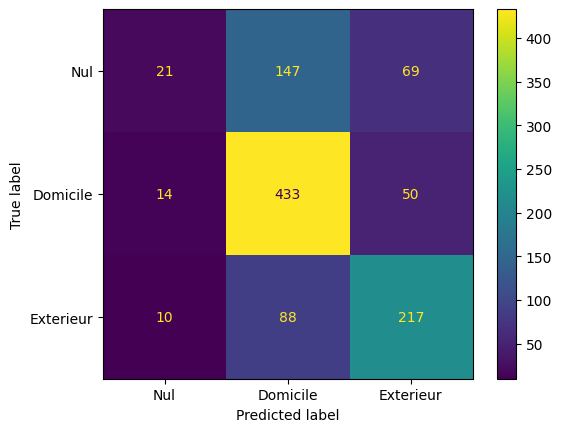

In [202]:
y_proba_result = result_model.predict_proba(X_test_score)

#for i in np.linspace(0.3,0.4, 20):
y_pred_score = [1 if x[1] > 0.33 else 2 if x[2] > 0.33 else 0 for x in y_proba_result]

accuracy_result = accuracy_score(y_test_score, y_pred_score)
#print(f'Threshold: {i} -> Accuracy: {accuracy_result}')
    
cm = confusion_matrix(y_test_score, y_pred_score)
ConfusionMatrixDisplay(cm, display_labels=['Nul', 'Domicile', 'Exterieur']).plot()

In [184]:
print(classification_report(y_test_score, y_pred_score))

              precision    recall  f1-score   support

           0       0.42      0.13      0.20       237
           1       0.67      0.85      0.75       497
           2       0.65      0.71      0.68       315

    accuracy                           0.65      1049
   macro avg       0.58      0.57      0.54      1049
weighted avg       0.61      0.65      0.61      1049



In [185]:
X_full_home = np.concatenate([X_train_score, X_test_score], axis=0)
y_pred_score_full = result_model.predict(X_full_home)

df_leagues['predicted_result'] = np.where( y_pred_score_full == 1, 'H',  np.where(y_pred_score_full == 2, 'A', 'D'))
df_leagues.head(5)

,league,home_goals,away_goals,home_team_form,home_team_league_pos,home_team_points_diff,home_team_home_form,home_team_home_league_pos,home_team_home_points_diff,home_team_average_goals_form,...,away_team_league_pos,away_team_points_diff,away_team_away_form,away_team_away_league_pos,away_team_away_points_diff,away_team_average_goals_form,away_team_average_xg_form,away_team_average_goals_form_against,away_team_average_xg_form_against,predicted_result
0,Premier League,1,0,0,1.0,0,0,1.0,0,0.000000,...,1.0,0,0,1.0,0,0.000000,0.000000,0.000000,0.000000,A
1,Premier League,1,3,8,14.0,6,4,15.0,5,1.000000,...,7.0,-2,5,2.0,2,1.000000,0.633333,1.000000,1.533333,H
2,Premier League,1,1,0,1.0,0,0,1.0,0,0.000000,...,1.0,0,0,1.0,0,0.000000,0.000000,0.000000,0.000000,A
3,Premier League,2,1,7,10.0,-12,4,7.0,-5,1.666667,...,8.0,1,0,19.0,0,1.666667,1.833333,1.666667,1.300000,H
4,Premier League,1,0,6,9.0,-2,2,12.0,-4,0.666667,...,18.0,-1,1,17.0,-2,0.666667,1.033333,1.000000,1.066667,H


### Alternative

In [59]:
df_leagues_scores_copy = df_leagues_scores.copy()

y_home = [1 if result in [1, 0] else 0 for result in df_leagues_scores_copy['result']]  # 1 = Home / Doubt, 0 = Away
y_away = [1 if result in [2, 0] else 0 for result in df_leagues_scores_copy['result']]  # 1 = Away / Doubt, 0 = Home

del df_leagues_scores_copy['home_goals']
del df_leagues_scores_copy['away_goals']
del df_leagues_scores_copy['result']

df_leagues_scores_home = df_leagues_scores_copy.copy()
df_leagues_scores_away = df_leagues_scores_copy.copy()
df_leagues_scores_home['home_result'] = y_home
df_leagues_scores_away['away_result'] = y_away

df_train_score_home, df_test_score_home, y_train_score_home, y_test_score_home = get_train_test_split(df_leagues_scores_home, 'home_result')
df_train_score_away, df_test_score_away, y_train_score_away, y_test_score_away = get_train_test_split(df_leagues_scores_away, 'away_result')

X_train_score_home, X_test_score_home, dict_home = get_X_train_test(df_train_score_home, df_test_score_home)
X_train_score_away, X_test_score_away, dict_away = get_X_train_test(df_train_score_away, df_test_score_away)

df_result_accuracy = pd.DataFrame(columns=['max_depth', 'n_estimators', 'min_samples_split', 'accuracy_home', 'accuracy_away'])

for max_depth in tqdm(range(10,40,2)):
    print(f'Max depth: {max_depth}')
    for n_estimator in range(200, 600, 50):
        for min_samples_split in range(2,16,2):
            home_or_draw_model = RandomForestClassifier(max_depth=20, 
                                                n_estimators=450,
                                                min_samples_split=2,
                                                random_state=42)
        
            away_or_draw_model = RandomForestClassifier(max_depth=14, 
                                                n_estimators=500,
                                                min_samples_split= 12,
                                                random_state=42)
            
            home_or_draw_model.fit(X_train_score_home, y_train_score_home)
            away_or_draw_model.fit(X_train_score_away, y_train_score_away)
            
            y_pred_result_home = home_or_draw_model.predict(X_test_score_home)
            y_pred_result_away = away_or_draw_model.predict(X_test_score_away)

            tmp_score_home = accuracy_score(y_test_score_home, y_pred_result_home)
            tmp_score_away = accuracy_score(y_test_score_away, y_pred_result_away)
            
            df_temp = pd.DataFrame([{'max_depth':max_depth,
                                        'n_estimators': n_estimator,
                                        'min_samples_split':min_samples_split,
                                        'accuracy_home':tmp_score_home,
                                        'accuracy_away':tmp_score_away}])
            
            if df_result_accuracy.empty:
                df_result_accuracy = df_temp
            else:
                df_result_accuracy = pd.concat([df_result_accuracy, df_temp], ignore_index = True)

  0%|          | 0/15 [00:00<?, ?it/s]

Max depth: 10
Max depth: 12
Max depth: 14
Max depth: 16
Max depth: 18
Max depth: 20
Max depth: 22
Max depth: 24
Max depth: 26
Max depth: 28
Max depth: 30
Max depth: 32
Max depth: 34
Max depth: 36
Max depth: 38


In [61]:
df_result_accuracy = df_result_accuracy.sort_values('accuracy_home', ascending=False)
df_result_accuracy.head(10)

,max_depth,n_estimators,min_samples_split,accuracy_home,accuracy_away
0,10,200,2,0.789033,0.724296
577,30,300,8,0.789033,0.724296
553,28,550,2,0.789033,0.724296
554,28,550,4,0.789033,0.724296
555,28,550,6,0.789033,0.724296
556,28,550,8,0.789033,0.724296
557,28,550,10,0.789033,0.724296
558,28,550,12,0.789033,0.724296
559,28,550,14,0.789033,0.724296
560,30,200,2,0.789033,0.724296


In [71]:
home_or_draw_model = RandomForestClassifier(max_depth=20, 
                                                n_estimators=450,
                                                min_samples_split=2,
                                                random_state=42)
        
away_or_draw_model = RandomForestClassifier(max_depth=14, 
                                    n_estimators=500,
                                    min_samples_split= 12,
                                    random_state=42)

home_or_draw_model.fit(X_train_score_home, y_train_score_home)
away_or_draw_model.fit(X_train_score_away, y_train_score_away)

home_or_draw_prob = home_or_draw_model.predict_proba(X_test_score_home)[:, 1]  
away_or_draw_prob = away_or_draw_model.predict_proba(X_test_score_away)[:, 1]

draw_proba = home_or_draw_prob + away_or_draw_prob - 1 
home_proba = home_or_draw_prob - draw_proba
away_proba = away_or_draw_prob - draw_proba

y_predictions = []
for draw, home, away in zip(draw_proba, home_proba, away_proba):
    if draw > max(home, away):
        y_predictions.append(0)
    elif home > away:
        y_predictions.append(1)
    else:
        y_predictions.append(2)
        
accuracy = accuracy_score(y_test_score, y_predictions)

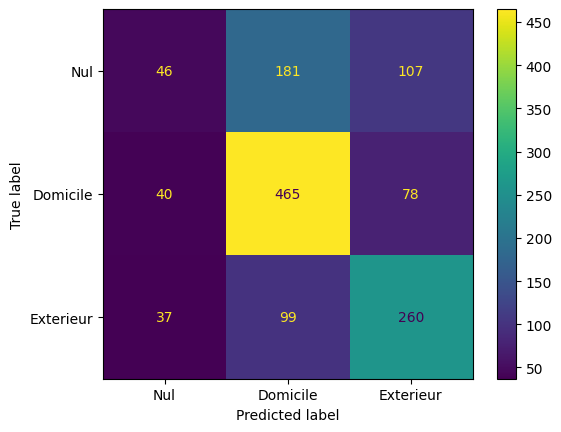

In [72]:
accuracy_result = accuracy_score(y_test_score, y_predictions)
#print(f'Threshold: {i} -> Accuracy: {accuracy_result}')
    
cm = confusion_matrix(y_test_score, y_predictions)
ConfusionMatrixDisplay(cm, display_labels=['Nul', 'Domicile', 'Exterieur']).plot()

In [74]:
print(classification_report(y_test_score, y_predictions))

              precision    recall  f1-score   support

           0       0.37      0.14      0.20       334
           1       0.62      0.80      0.70       583
           2       0.58      0.66      0.62       396

    accuracy                           0.59      1313
   macro avg       0.53      0.53      0.51      1313
weighted avg       0.55      0.59      0.55      1313



In [76]:
output_file_home = f'../model/model_result_home.bin'
output_file_away = f'../model/model_result_away.bin'

f_out_home = open(output_file_home, 'wb')
f_out_away = open(output_file_away, 'wb')

pickle.dump((dict_home, home_or_draw_model), f_out_home)
pickle.dump((dict_away, away_or_draw_model), f_out_away)

f_out_home.close()
f_out_away.close()